<h1 style="color: rebeccapurple;">Unsupervised Learning - Clustering</h1>
<span style="text-transform: uppercase;
        font-size: 14px;
        letter-spacing: 1px;
        font-family: 'Segoe UI', sans-serif;">
    Author
</span><br>
efrén cruz cortés
<hr style="border: none; height: 1px; background: linear-gradient(to right, transparent 0%, #ccc 10%, transparent 100%); margin-top: 10px;">

## <span style="color:darkorchid">Imports</span>

In [1]:
# Scikit-learn specifics:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics

# Helper modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## <span style="color:darkorange">Conceptual Intermezzo - Clustering</span>

See slides

## <span style="color:darkorchid">Alice's Medical Mission

Alice is researching cancer cells. She has images of breast mass samples, and wants to know if it is possible to identify different groups of cells, which according to aprior knowledge represent malignant and benign tissue. The only data available to her are the cell nucleus characteristics presented in the images. Here is one such image:

![breast-tissue](images/breast-tissue.png){width=50%}

Alice's main reasoning is below:
* Since she doesn't know exactly which cells are benign and which malignant, only that there are two different types, this is a **clustering** task.
* The main **assumption** is that there are only two clusters recognizable in the data.
* The **interpretation** of these clusters are to benign and malignant tissue cells.

**Feature Extraction**<br>
We are not going to work directly from the image data, instead, Alice uses a computer vision tool to extract features like radius, smoothness, degree of symmetry, and others from the images. The data we will work with are these extracted features.

### <span style="color:teal"> Gather the data

In [2]:
data_dir = 'https://raw.githubusercontent.com/nuitrcs/scikit-learn-workshop/main/data/breast_cancer_wisconsin_clustering.csv'
breast_df = pd.read_csv(data_dir)
breast_df.shape

(569, 10)

Let's take a quick look at the first few rows:

In [3]:
breast_df.head()

,radius,texture,perimeter,area,smoothness,compactness,concavity,concave points,symmetry,fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


**Note**

Contrary to the case of supervised learning (regression and classification), we *DON'T have a target column*! This will be the standard for clustering problems.

### <span style="color:teal">Explore the data

**Assumption**<br>
Remember our big assumption: clusters are identifiable from the structure of the data.

**Dimensionality**<br>
Each point in the data is a 10-dimensional vector. We can't visualize 10-dimensional points. So let's look at their pairwise relationships and see if we can make up some clusters:

Our first question may be, does the data actually show a separation? Let's take a closer look. I'll plot all possible pairwise scatter plots (over the 10 features).

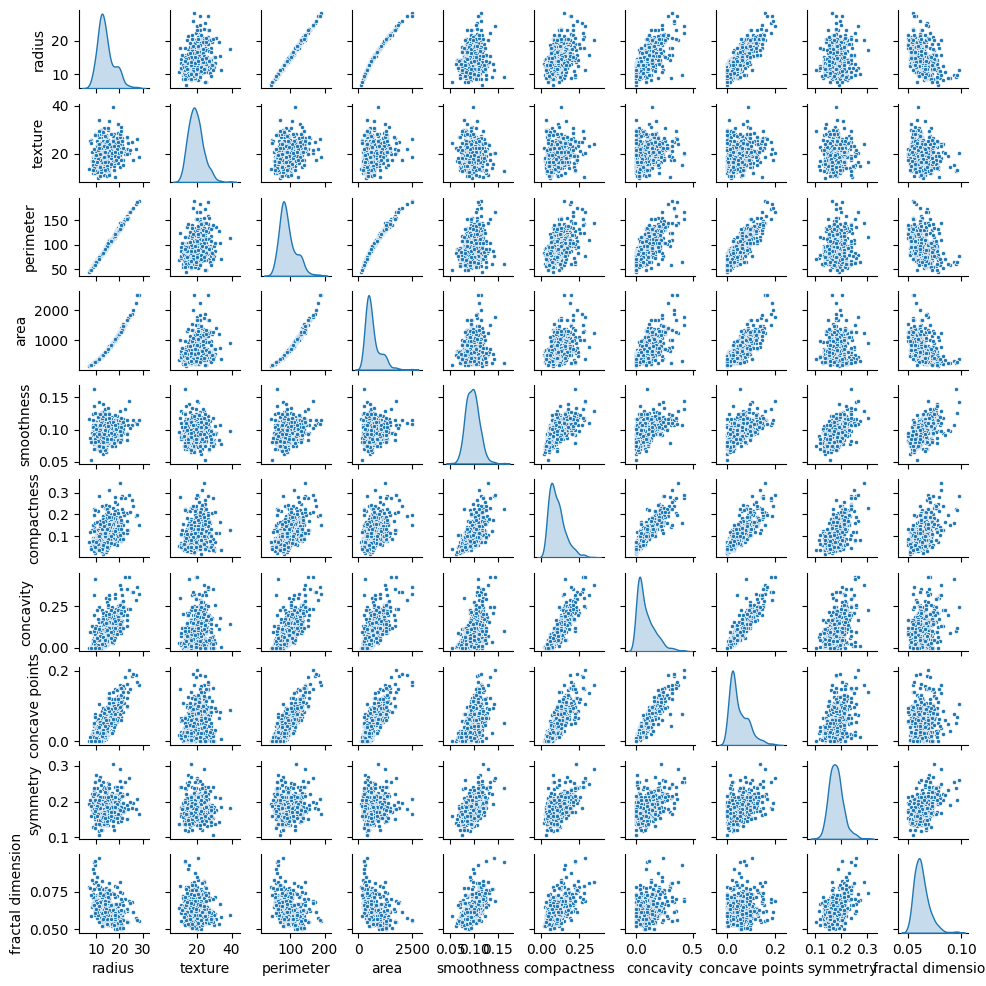

In [4]:
# This takes a while if running on Google Colab. ONLY run if not showing already.
sns.pairplot(breast_df, diag_kind = 'kde', height=1, markers='.');

Well well, not as clean as we wished. But remember we are only looking at 2-d slices of a 10-d object. Indeed, if we take a closer look at area and smoothness, we start seeing some separation:

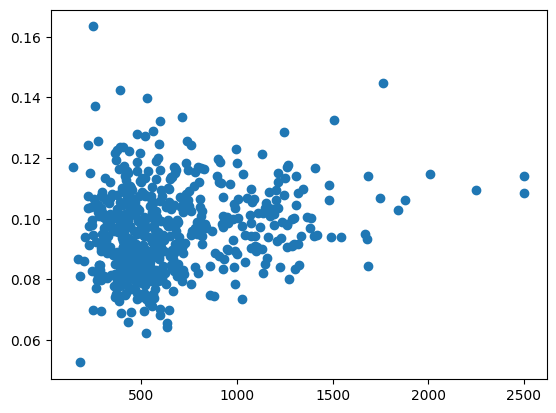

In [5]:
plt.scatter(breast_df["area"], breast_df["smoothness"]);

**Separation?**<br>
It is faint, but there seems to be a separation around the 800 area value. It is possible this separation will accumulate over the 10 dimensions, and we can get two distinct clusters?

### <span style="color:teal">Preprocess the data

We will use a standard scaler.

**(Note - what if we run into categorical data?)**<br>
Dealing with categorical variables in clustering is not so straighforward. An easy hack is to use one-hot encoding as learned in previous sessions. However, the best practice is to use clustering algorithms specific for categorical and mixed data, for example k-modes.

In [6]:
# Create Scaler object
scaler = StandardScaler().set_output(transform='pandas')
# fit the scaler
scaler.fit(breast_df)
# Scale the data
breast_data_scaled = scaler.transform(breast_df)

### <span style="color:red">EXERCISE - Bo's lost labels

As you may remember, Bo set out to collect data on different species of the Iris genus. Unfortunately, the villanous Dr. Mac G. Uffin has stolen the true labels. Without labels, Bo's task is now to find clusters. Each cluster represents samples from a different species.
Below I have loaded the data and made some plots for you.

![macguffin](images/villanous_macguffin.png){width=40%}

In [7]:
# Get iris dataset using sklearn
iris = datasets.load_iris(as_frame = True)
iris = iris.data # Only use the data, not the target
iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


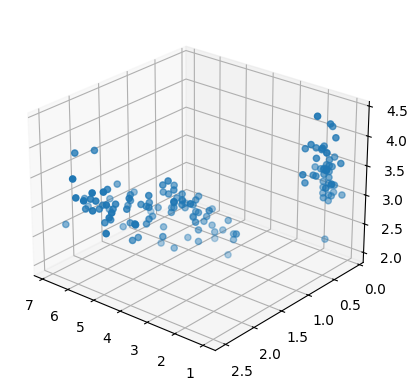

In [8]:
# I'll help with step 3:
fig = plt.figure()
ax = fig.add_subplot(projection = "3d", elev=25, azim=130)
ax.scatter(iris['petal length (cm)'], iris['petal width (cm)'], iris['sepal width (cm)'])
plt.show()

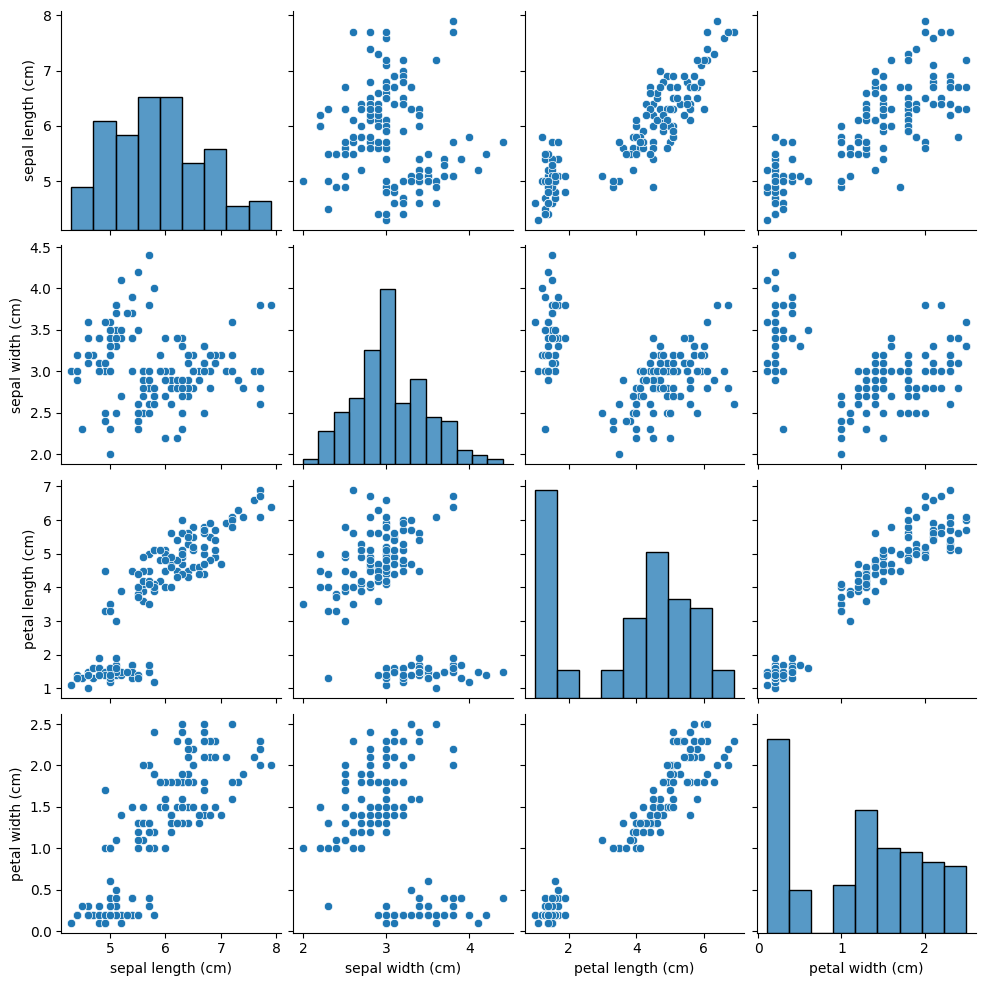

In [9]:
# I'll do this step for you also.
sns.pairplot(iris)
plt.show()

**TASKS**


1. Looking at the plots, how many different types of species do you think were collected? Discuss with your neighbor.

2. Scale the data, let's use a standard scaler, unless you want to experiment with something else.

Scale the iris dataset:

(Use names like `iris_scaler` and `iris_scaled` to differentiate from the scaler in the examples.)

In [16]:
# Create scaler and scale

### <span style="color:teal">Clustering with k-means

**Different algorithms**<br>
This part is tricky, there are a few different types of clustering algorithms and they are based on different principles. Some clustering algorithms try to find clouds of high density, while others try to form clusters that are tight internally but separate from each other.

We will look at two common clustering algorithms: **k-means** and **DBSCAN**. Here is a plot from scikit-learn comparing different types of clustering algorithms.

**How to choose?**<br>
The important thing to know is that when the data is "curved" or has a weird geometry. Algorithms like DBSCAN perform better. But if your data is more blob-like, k-means is a good choice.

![clustering-sklearn](images/clustering_comparison.png){width=70%}

k-means produces the cluster assignments and also a "centroid" for each cluster.

In [10]:
kmeans_model = KMeans(n_clusters = 2)
kmeans_model

KMeans(n_clusters=2)

In [11]:
kmeans_model.fit(breast_data_scaled)

KMeans(n_clusters=2)

Mmm, OK so what is the output?

Remember, clustering assigns a cluster to each data point, so we should have an assignment to one of two clusters for each data point. Let's see:

In [12]:
kmeans_model.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,

In [13]:
C = kmeans_model.cluster_centers_
C

array([[ 1.11284089,  0.49969358,  1.14449628,  1.10246171,  0.65263368,
         1.07334327,  1.19072792,  1.26938614,  0.61761183,  0.17709167],
       [-0.47813013, -0.21469247, -0.49173081, -0.47367074, -0.28040291,
        -0.46116005, -0.51159416, -0.54538952, -0.26535584, -0.07608713]])

Great! Let's do some sanity check, by plotting as above but with the labels:


In [14]:
breast_data_scaled.head()

,radius,texture,perimeter,area,smoothness,compactness,concavity,concave points,symmetry,fractal dimension
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450


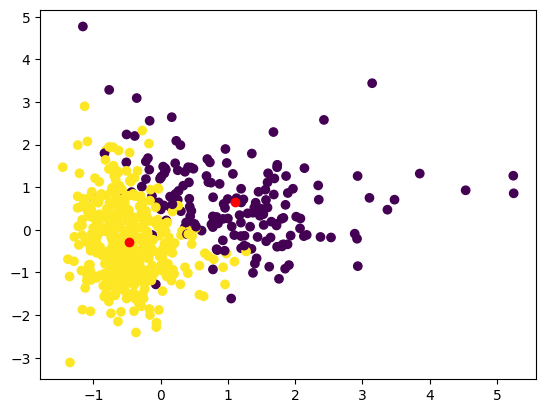

In [15]:
# Remember sklearn works mostly with numpy arrays, our data right now is in pandas df format...
# ... no problem, let's just match column names with column indices in a dictionary so we don't mess up
viz_feature_1 = {'name': 'area', 'index': 3}    # <- you can choose others if you want to
viz_feature_2 = {'name': 'smoothness', 'index': 4}
viz_feature_3 = {'name': 'concave points', 'index': 7}

plt.scatter(breast_data_scaled[viz_feature_1['name']], breast_data_scaled[viz_feature_2['name']], c = kmeans_model.labels_)
plt.scatter(C[:,viz_feature_1['index']],C[:,viz_feature_2['index']], c = "red")
plt.show()

Indulge me in visualizing the 3d structure again:

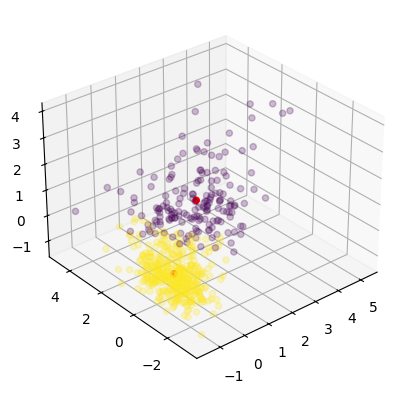

In [16]:
fig = plt.figure()
ax = fig.add_subplot(projection = "3d")
ax.scatter(
    breast_data_scaled[viz_feature_1['name']],
    breast_data_scaled[viz_feature_2['name']],
    breast_data_scaled[viz_feature_3['name']],
    alpha = .25, c = kmeans_model.labels_)

ax.scatter(
    C[:,viz_feature_1['index']],
    C[:,viz_feature_2['index']],
    C[:,viz_feature_3['index']],
    c = "red", alpha=1)

ax.view_init(elev=30, azim=-130)
plt.show()

### <span style="color:red">EXERCISE - Bo's Iridiscent Irises

In spite of Dr. Mac G. Uffin's efforts, Bo keeps some apriori knowledge: they collected samples from $3$ different species of irises. That means that even if we don't know which samples are from which species, or how many samples of each species we have, we can reasonably expect $3$ clusters.

Run kmeans for the scaled iris dataset.

![iris-flowers](images/iris.png){width=75%}

In [24]:
# Create a kmeans object


In [25]:
# Fit it to the data


In [26]:
# Get the centroids


In [27]:
# :: Plot

# Step 1 - plot the scaled data, color according to assigned cluster labels
# plt.scatter(iris_scaled[:, 1], iris_scaled[:,2], c = kmeans_iris.labels_)     # <-- rename if needed
# plt.scatter(C_iris[:,1],C_iris[:,2], c = "red")
# plt.show()

### <span style="color:teal">Evaluate the model

**No ground truth**<br>
Model evaluation for unsupervised methods is quite tricky, since there is no truth to compare to. There are, however, some heuristics that help us find our footing.
* Inertia: Inertia is basically the within-clusters sum of squares. It represents how packed points are within each cluster.
* Silhouette Coefficient (SC): this coefficient is easier to interpret since it ranges from $-1$ to $1$, $1$ being the case where clusters are internally cohesive and well separated.

These methods are not fail-safe. Some models may, for example, have low SC and still have the wrong number of clusters. However, they are useful for comparing models and hyperparamters, as we'll see in a moment.

In [17]:
sc_score = metrics.silhouette_score(breast_data_scaled, kmeans_model.labels_, metric='euclidean')
inertia = kmeans_model.inertia_

print(f"Silhhouette Coefficient: {sc_score:.3f} \nIntertia: {inertia:.3f}")

Silhhouette Coefficient: 0.393 
Intertia: 3481.611


## <span style="color:darkorchid">Hyperparameter selection

**How many clusters?**<br>
Both Alice and Bo used apriori scientific knowledge to correctly identify the number of clusters. However, this information is not known in general.

**The Elbow Plot**
One way to see which number of clusters is best is to compute the inertia for different number of clusters. This will create an *elbow plot*. The inflection point is a good trade-off between performance and complexity, and used as a heuristic for choosing number of clusters. (Note: this method is specific for k-mean and inertia, other clustering algorithms use different parameters and metrics).

In [18]:
# Elbow plot
inertia_values = []
Kvals = np.arange(1,10)
for K in Kvals:
  m_K = KMeans(n_clusters = K)
  m_K.fit(breast_data_scaled)
  inertia_values.append(m_K.inertia_)

Plotting SC's elbow plot. Inflection point is better.

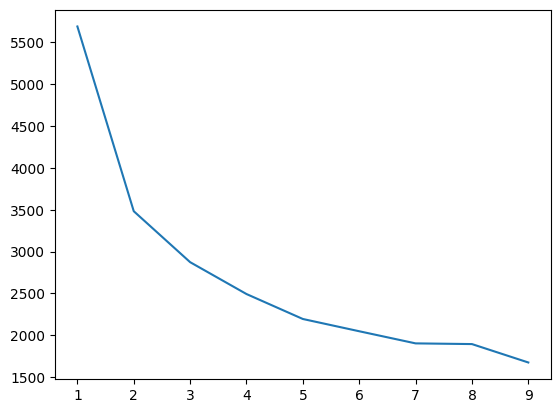

In [19]:
plt.plot(Kvals, inertia_values)
plt.show()

Seems like the biggest inflection (smaller angle) is around $2$. Good! That's what we wanted.

#### <span style="color:red">EXERCISE

* Create an elbow plot for the iris dataset.
* At what value of K is there an inflection point?
* Is it straighforward to decide?

In [ ]:
iris_inertia_values = []
Kvals = np.arange(1,10)
for K in Kvals:
  m_K = KMeans() # <-- Fill this in
  m_K.fit() # <-- Fill this in
  iris_inertia_values.append(m_K.inertia_)

In [ ]:
plt.plot(Kvals, iris_inertia_values)
plt.show()

## <span style="color:darkorchid">Conclusion

* Unsupervised learning does not have a ground truth to compare to.
* We must rely on domain knowledge and data structure.
* k-means and DBSCAN are popular clustering algorithms.
    * k-means scales well. Works for "blob" type of data. Depends heavily on chosen number of clusters.
    * DBSCAN is better suited for curved data. Depends on other parameters.
* You can choose the number of clusters using the elbow plot heuristic.
    * But remember, in general there is no ground truth to compare to.

 Clustering is a very common machine learning task. Often, the number of clusters is "incorrect". This results in a few extra clusters of small size that in many cases can be ignored and are taken as a loss. The more domain knowledge you have, and the more you explore the data, the better!